In [103]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage
import time
from sklearn.metrics import mean_absolute_error

In [127]:
# img = cv2.imread('../islands-300.jpeg')/255.0
img = cv2.imread('../Волков АК.jpg')/255.0
max_size = 1000
H, W = img.shape[0], img.shape[1]
if H > W:
    if H > max_size:
        img = cv2.resize(img, (int(W * max_size / H), max_size))
else:
    if W > max_size:
        img = cv2.resize(img, (max_size, int(H * max_size / W)))
        
H, W = img.shape[0], img.shape[1]
padding = int(W * 0.1 if H > W else H * 0.1)
zeros = np.zeros((H + padding * 2, W + padding * 2, 3))
zeros[padding: padding + H, padding: padding + W] = img
img = zeros
mask_img = np.zeros(img.shape)

blurs = dict()
for i in range(1, 100):
    blurs[i] = cv2.blur(img, (i, i))

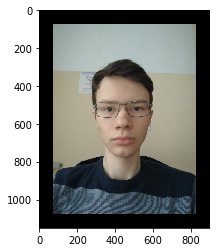

In [128]:
plt.imshow(img[:,:,::-1])

In [129]:
class Stroke():
    def __init__(self, image, dispersion, amount, speed, ttl, wide):
        image_size = image.shape[:2]
        self.dispersion = dispersion
        x = np.random.randint(0, image_size[1], 1)
        y = np.random.randint(0, image_size[0], 1)
        self.center = np.concatenate([x, y], axis=0).astype(np.float)
        self.offset = np.zeros((2, amount), dtype=np.float)
        
        self.particles_angle = np.random.uniform(0, 2 * np.pi, amount)
        self.particles_radius = np.fabs(np.random.normal(0, dispersion*2, amount))
        
        self.offset[0] = np.cos(self.particles_angle) * self.particles_radius
        self.offset[1] = np.sin(self.particles_angle) * self.particles_radius
        
        self.angle = np.random.uniform(0, 2 * np.pi)
        self.rotation = np.random.uniform(-np.pi/60, np.pi/60)
        self.color = image[y[0], x[0]]
        self.speed = np.random.normal(speed, speed/3, 1)
        self.status = 'running'
        self.ttl = np.random.normal(ttl)
        self.ttl = 0.5 if self.ttl < 0.5 else self.ttl
        self.wide = wide
        
        
    def get_mean_color(self, image, x, y):
        if 0 < x < image.shape[1] and 0 < y < image.shape[0]:
            return blurs[self.dispersion][int(y), int(x)]
        else:
            return self.color
        
        
    def update(self, image):  
        # add removal of some points
        self.last_center = self.center.copy()
        self.last_offset = self.offset.copy()
        self.angle += self.rotation
        self.particles_angle += self.rotation
        
        self.center[0] += np.cos(self.angle) * self.speed
        self.center[1] += np.sin(self.angle) * self.speed
        self.offset[0] = np.cos(self.particles_angle) * self.particles_radius
        self.offset[1] = np.sin(self.particles_angle) * self.particles_radius
        
        mean_color = self.get_mean_color(image, self.center[0], self.center[1])
        self.color = self.color - (self.color - mean_color)/2
        self.ttl -= np.random.uniform(0, 0.05)
        if self.ttl <= 0:
            self.status = 'deleted'
        
        
    def draw(self, image):
        last_positions = (self.last_center.reshape(2, 1) + [self.last_offset[0], self.last_offset[1]]).T.reshape(-1, 1, 2)
        positions = (self.center.reshape(2, 1) + [self.offset[0], self.offset[1]]).T.reshape(-1, 1, 2)
        points = np.concatenate([last_positions, positions], axis=1).astype(np.int32)
        cv2.polylines(image, points, False, self.color, self.wide)   
        

In [130]:
max_image_size = max(img.shape[:2])
max_strokes_base = int(200 * (max_image_size / 1150))
max_strokes_base = 2 if max_strokes_base < 2 else max_strokes_base
strokes_amount_base = int(10 * (max_image_size / 500))
strokes_amount_base = 1 if strokes_amount_base < 1 else strokes_amount_base
min_dispersion_base = int(10 * (max_image_size / 1150))
min_dispersion_base = 1 if min_dispersion_base < 1 else min_dispersion_base
max_dispersion_base = int(30 * (max_image_size / 1150))
max_dispersion_base = 2 if max_dispersion_base < 2 else max_dispersion_base
min_amount_base = int(50 * (max_image_size / 1150))
min_amount_base = 1 if min_amount_base < 1 else min_amount_base
max_amount_base = int(100 * (max_image_size / 1150))
max_amount_base = 2 if max_amount_base < 2 else max_amount_base
speed_base = int(10 * (max_image_size / 1150))
speed_base = 1 if speed_base < 1 else speed_base
ttl_base = int(5 * (max_image_size / 1150))
ttl_base = 1 if ttl_base < 1 else ttl_base
wide_base = int(5 * (max_image_size / 1150))
wide_base = 2 if wide_base < 2 else wide_base

strokes_amount = strokes_amount_base
min_dispersion = min_dispersion_base
max_dispersion = max_dispersion_base
min_amount = min_amount_base
max_amount = max_amount_base
speed = speed_base
ttl = ttl_base
wide = wide_base

print('strokes_amount',  strokes_amount_base)
print('min_dispersion',  min_dispersion_base)
print('max_dispersion',  max_dispersion_base)
print('min_amount',  min_amount_base)
print('max_amount',  max_amount_base)
print('speed',  speed_base)
print('ttl',  ttl_base)

strokes = [Stroke(img, 
                  dispersion=np.random.randint(min_dispersion, max_dispersion), 
                  amount=np.random.randint(min_amount, max_amount),
                  speed=speed,
                  ttl=ttl,
                  wide=wide) for _ in range(strokes_amount)]
total_img_value = img.sum()
error = 1
iterations = 1
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
vid = cv2.VideoWriter('temp.mp4', fourcc, 100, (img.shape[1], img.shape[0]) )
print(img.shape[1], img.shape[0])
print(mask_img.shape[1], mask_img.shape[0])

start = time.time()

# while error > (0.1 / ((max_image_size / 1000) ** 0.5)) and iterations < 5000:
while iterations < 3000:
    strokes = [st for st in strokes if st.status != 'deleted']
    for _ in range(strokes_amount - len(strokes)):
        strokes.append(Stroke(img, 
                              np.random.randint(int(min_dispersion), int(max_dispersion)), 
                              np.random.randint(int(min_amount), int(max_amount)),
                              speed=speed,
                              ttl=ttl,
                              wide=wide))
        
    for st in strokes:
        st.update(img)
        st.draw(mask_img)
        
    if iterations % 200 == 0:
        error = np.abs((img - mask_img)).sum() / total_img_value
        min_dispersion = min_dispersion_base - ((min_dispersion_base - 1) * ((1 - error) ** 1))
        max_dispersion = max_dispersion_base - ((max_dispersion_base - 2) * ((1 - error) ** 1))
        min_amount = min_amount_base - ((min_amount_base - 1) * ((1 - error) ** 1))
        max_amount = max_amount_base - ((max_amount_base - 5) * ((1 - error) ** 1))
        speed = speed_base - (speed_base * 0.9 * (1 - error))
        strokes_amount = int(strokes_amount_base + (max_strokes_base - strokes_amount_base) * ((1 - error) ** 8))
        ttl = ttl_base - ((ttl_base - 1) * (1 - error))
        wide = int(wide_base - ((wide_base - 1) * ((1 - error) ** 5)))
        print(iterations, error)
        
    vid.write((mask_img*255).astype(np.uint8))
        
    cv2.imshow('BlindArtist', mask_img)
    key = cv2.waitKey(1)
    if key == 27:      # esc
        break
    
    iterations += 1

end = time.time()
print(f'total time: {end-start}')
        
vid.release()
cv2.destroyAllWindows()

strokes_amount 23
min_dispersion 10
max_dispersion 30
min_amount 50
max_amount 100
speed 10
ttl 5
900 1150
900 1150
200 0.41841570462692834
400 0.26975390813733685
600 0.18815169484862235
800 0.14432670934799077
1000 0.11775815821786531
1200 0.10235180712472326
1400 0.08761637708059332
1600 0.07713948161126508
1800 0.07154106618051032
2000 0.06731046415633152
2200 0.06286802091521611
2400 0.0588738590370209
2600 0.05550990910874442
2800 0.05291013974050089
total time: 67.34966015815735


In [131]:
%%time
!ffmpeg -i temp.mp4 -vcodec h264  temp_compressed.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [83]:
vid = cv2.VideoWriter('temp2.mp4', fourcc, 100, (img.shape[1], img.shape[0]) )


In [ ]:
a = np.arange(0, 1, 0.01)

In [ ]:
plt.plot(np.arange(0, 100), a**1.5)
plt.plot(np.arange(0, 100), a)